[以泰坦尼克预测为例](https://jackiexiao.github.io/eat_pytorch_in_20_days/1.%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B/1-1%2C%E7%BB%93%E6%9E%84%E5%8C%96%E6%95%B0%E6%8D%AE%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B%E8%8C%83%E4%BE%8B/)

使用Pytorch实现神经网络模型的一般流程包括：

- 1，准备数据
- 2，定义模型
- 3，训练模型
- 4，评估模型
- 5，使用模型
- 6，保存模型。

## 1. 数据准备

In [45]:
"""
字段说明：

Survived:0代表死亡，1代表存活【y标签】
Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
Name:乘客姓名 【舍去】
Sex:乘客性别 【转换成bool特征】
Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
Parch:乘客父母/孩子的个数(整数值)【数值特征】
Ticket:票号(字符串)【舍去】
Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】
"""
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset

dftrain_raw = pd.read_csv('../../corpus/titanic/train.csv')
dftest_raw = pd.read_csv('../../corpus/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


In [46]:
torch.__version__

'1.11.0'

In [47]:
# 数据预处理, 转化为数值表示

def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]  # 乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )
x_train

x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [48]:
# 进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道。


dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()),
                     shuffle = True, batch_size = 8)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).float()),
                     shuffle = False, batch_size = 8)
# 测试数据管道
for features,labels in dl_train:
    print(features,'\n', labels)
    break

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 25.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.4200,  0.0000,  0.0000,
          1.0000,  8.5167,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  0.0000, 62.0000,  0.0000,  0.0000,
          0.0000, 80.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 18.0000,  0.0000,  0.0000,
          0.0000,  8.0500,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 18.0000,  0.0000,  0.0000,
          0.0000,  7.4958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 32.0000,  0.0000,  0.0000,
          0.0000,  7.8958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 24.0000,  0.0000,  0.0

## 2. 定义模型
![image.png](../pic/titanic_net.png)

In [49]:
# 使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，

def create_net():
    net = nn.Sequential()
    net.add_module("linear1",nn.Linear(15,20))
    net.add_module("relu1",nn.ReLU())
    net.add_module("linear2",nn.Linear(20,15))
    net.add_module("relu2",nn.ReLU())
    net.add_module("linear3",nn.Linear(15,1))
    net.add_module("sigmoid",nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [50]:
from torchkeras import summary
summary(net,input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


## 3. 训练模型

In [51]:
import datetime
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr = 0.01)
metric_func = lambda y_pred,y_true: accuracy_score(y_true.data.numpy(),y_pred.data.numpy()>0.5)
metric_name = "accuracy"

epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1,epochs+1):  

    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features,labels) in enumerate(dl_train, 1):

        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)

        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))

    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info

    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

print('Finished Training...')

Start Training...
================================================================================2022-04-04 12:34:39
[step = 30] loss: 0.680, accuracy: 0.621
[step = 60] loss: 0.670, accuracy: 0.617

EPOCH = 1, loss = 0.665,accuracy  = 0.633, val_loss = 0.612, val_accuracy = 0.703

================================================================================2022-04-04 12:34:39
[step = 30] loss: 0.564, accuracy: 0.721
[step = 60] loss: 0.582, accuracy: 0.715

EPOCH = 2, loss = 0.580,accuracy  = 0.702, val_loss = 0.506, val_accuracy = 0.783

================================================================================2022-04-04 12:34:39
[step = 30] loss: 0.558, accuracy: 0.725
[step = 60] loss: 0.528, accuracy: 0.750

EPOCH = 3, loss = 0.537,accuracy  = 0.746, val_loss = 0.487, val_accuracy = 0.799

================================================================================2022-04-04 12:34:40
[step = 30] loss: 0.549, accuracy: 0.758
[step = 60] loss: 0.502, accuracy: 0.779

E

## 4 评估模型

In [52]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.665466,0.633427,0.611808,0.702899
1,2.0,0.579567,0.702247,0.506248,0.782609
2,3.0,0.537351,0.745787,0.486522,0.798913
3,4.0,0.517581,0.769663,0.461772,0.798913
4,5.0,0.491138,0.793539,0.445229,0.782609
5,6.0,0.487504,0.785112,0.454493,0.804348
6,7.0,0.472990,0.796348,0.437057,0.782609
7,8.0,0.443901,0.803371,0.414329,0.820652
8,9.0,0.460493,0.796348,0.525413,0.768116
9,10.0,0.439027,0.797753,0.437995,0.804348


In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

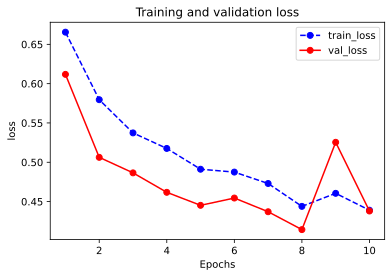

In [54]:
plot_metric(dfhistory,"loss")

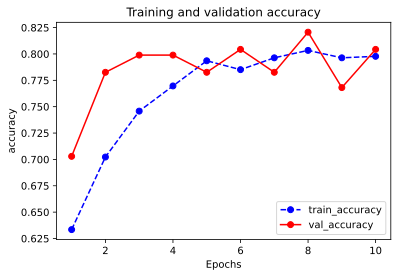

In [55]:
plot_metric(dfhistory,"accuracy")


## 5 使用模型

In [56]:
#预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.1843],
        [0.7557],
        [0.4434],
        [0.5616],
        [0.5380],
        [0.9559],
        [0.2303],
        [0.7949],
        [0.4790],
        [0.2333]])

In [57]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])

## 6 保存模型
Pytorch 有两种保存模型的方式，都是通过调用pickle序列化方法实现的。

第一种方法只保存模型参数。

第二种方法保存完整模型。

推荐使用第一种，第二种方法可能在切换设备和目录的时候出现各种问题。



### 6.1 保存模型参数

In [58]:
print(net.state_dict().keys())
net.state_dict().values()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


odict_values([tensor([[-5.1933e-01, -4.4852e-01,  9.7792e-01, -2.3438e+00,  1.5769e+00,
          1.6520e-01,  7.8601e-01,  2.1645e-01, -2.0570e-01, -1.7990e-01,
          7.0989e-01, -3.3866e-01,  3.1233e-01,  4.4158e-02, -4.4153e-01],
        [ 2.2229e-02, -1.0197e-01, -5.9885e-03,  2.9372e-01, -2.2275e-01,
         -3.4256e-02, -3.2816e-01, -1.8888e-01,  5.1460e-03, -4.6718e-02,
         -4.9128e-02, -9.2215e-02, -3.1845e-01, -1.1398e-01,  2.3422e-01],
        [ 8.9925e-01,  2.8490e-02,  2.6249e-01, -3.1044e-01,  1.0329e+00,
         -7.7151e-01,  6.6586e-01, -3.7106e-01, -5.8169e-01, -1.5383e-01,
          5.5130e-01, -3.6687e-01,  5.6008e-02,  9.1860e-01,  1.8499e-01],
        [-1.4952e-01,  1.5506e-03, -1.1764e-01, -9.6953e-02,  4.3202e-02,
          1.1524e-02, -1.5407e-01,  1.3136e-01, -2.2372e-02, -1.9367e-01,
         -3.2534e-02, -1.0966e-01, -1.0772e-01, -1.9741e-01,  3.5668e-02],
        [-2.3521e-01,  7.8225e-02, -4.4470e-02,  8.9867e-03, -1.0442e-01,
         -7.8563e-02

In [59]:
# 保存模型参数

torch.save(net.state_dict(), "../../model/test/net_parameter.pkl")

net_clone = create_net()
net_clone.load_state_dict(torch.load("../../model/test/net_parameter.pkl"))

net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1843],
        [0.7557],
        [0.4434],
        [0.5616],
        [0.5380],
        [0.9559],
        [0.2303],
        [0.7949],
        [0.4790],
        [0.2333]])

### 6.2 保存完整模型

In [60]:
torch.save(net, '../../model/test/net_model.pkl')
net_loaded = torch.load('../../model/test/net_model.pkl')
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1843],
        [0.7557],
        [0.4434],
        [0.5616],
        [0.5380],
        [0.9559],
        [0.2303],
        [0.7949],
        [0.4790],
        [0.2333]])